# Generating templates and recordings with non-rigid drifts

This notebook shows how to generate templates and recordings from scratch using MEArec.

The last part of the notebook showcases some plotting routines available through the package.

In [1]:
import MEArec as mr
import MEAutility as mu
import yaml
from pprint import pprint
import matplotlib.pylab as plt
import numpy as np
from pathlib import Path

%matplotlib notebook

## Load default configuration files

First, let's load the default configuration of MEArec

In [2]:
default_info, mearec_home = mr.get_default_config()
pprint(default_info)

{'cell_models_folder': '/home/alessio/.config/mearec/1.8.0.dev0/cell_models/bbp',
 'recordings_folder': '/home/alessio/.config/mearec/1.8.0.dev0/recordings',
 'recordings_params': '/home/alessio/.config/mearec/1.8.0.dev0/default_params/recordings_params.yaml',
 'templates_folder': '/home/alessio/.config/mearec/1.8.0.dev0/templates',
 'templates_params': '/home/alessio/.config/mearec/1.8.0.dev0/default_params/templates_params.yaml'}


## Generating and saving templates

In [3]:
# define cell_models folder
cell_folder = default_info['cell_models_folder']
template_params = mr.get_default_templates_params()
pprint(template_params)

{'beta_distr_params': [1.5, 5],
 'check_for_drift_amp': False,
 'cut_out': [2, 5],
 'delay': 10,
 'drift_steps': 31,
 'drift_within_bounds': False,
 'drift_xlim': [-10, 10],
 'drift_ylim': [-10, 10],
 'drift_zlim': [30, 80],
 'drifting': False,
 'dt': 0.03125,
 'max_drift': 100,
 'max_iterations': 1000,
 'min_amp': 30,
 'min_drift': 30,
 'n': 50,
 'ncontacts': 10,
 'offset': 0,
 'overhang': 30,
 'probe': 'Neuronexus-32',
 'rot': 'physrot',
 'seed': None,
 'sim_time': 1,
 'target_spikes': [3, 50],
 'timeout': None,
 'weights': [0.25, 1.75],
 'x_distr': 'uniform',
 'xlim': [10, 80],
 'ylim': None,
 'zlim': None}


Now let's change a few parameters and generate templates. We need to generate templates with drift. In order to use the advanced drift features, we have to make sure that all templates drift roughly in the same direction and by the same distance.

In [4]:
template_params["drifting"] = True
template_params["drift_steps"] = 30
# this ensures that all cells drift on the same z trajectory, with a small xy variation
template_params["drift_xlim"] = [-5, 5]
template_params["drift_ylim"] = [-5, 5]
template_params["drift_zlim"] = [100, 100]
template_params["max_drift"] = 200

# let's generate 50 templates per cell models (total 650 templates)
template_params["n"] = 20
template_params['probe'] = 'Neuropixels-32'

In [5]:
templates_path = Path("data/test_drift_templates.h5")

In [6]:
if not templates_path.is_file():
    # the templates are not saved, but the intracellular simulations are saved in 'templates_folder'
    tempgen = mr.gen_templates(cell_models_folder=cell_folder, params=template_params, n_jobs=13, verbose=1)
    # this will take a few minutes...
else:
    tempgen = mr.load_templates(templates_path, return_h5_objects=False)

The `tempgen` variable is a `TemplateGenerator` object. It contains the `templates`, `locations`, `rotations`, and `celltypes` of the generated templates.

In [7]:
print('Templates shape', tempgen.templates.shape)

Templates shape (260, 30, 32, 224)


<IPython.core.display.Javascript object>


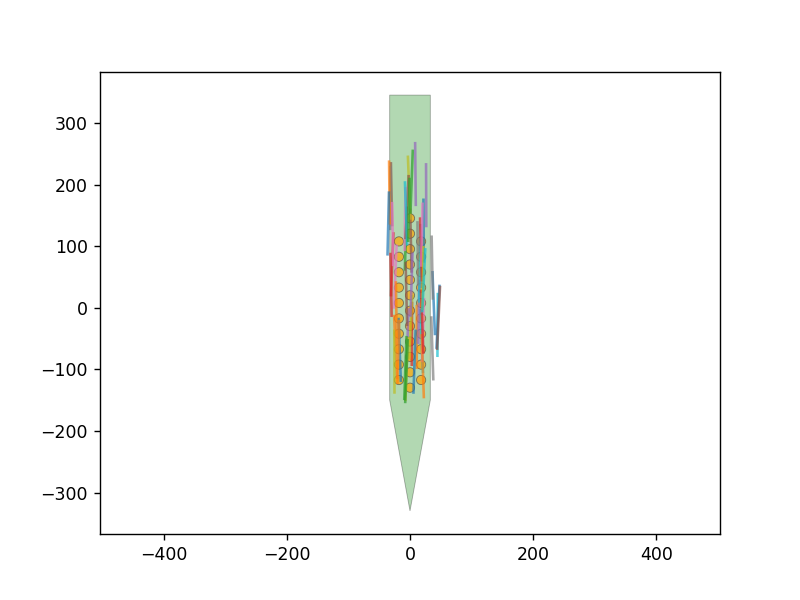

In [8]:
# plot locations
probe = mu.return_mea(info=tempgen.info["electrodes"])

ax_probe = mu.plot_probe(probe)
for loc in tempgen.locations[::5]:
    ax_probe.plot([loc[0, 1], loc[-1, 1]], [loc[0, 2], loc[-1, 2]], alpha=0.7)

We can now save the `TemplateGenerator` object in h5 format.

In [9]:
if not templates_path.is_file():
    # save templates in h5 format
    mr.save_template_generator(tempgen, filename=templates_path)

## Generating and saving drift recordings with 1 drift signal

Once the templates have been generated, we can use them to generate recordings. Let's fisrt load and take a look at the default parameters:

In [10]:
recordings_params = mr.get_default_recordings_params()
pprint(recordings_params)

{'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
                'inhibitory': ['AC',
                               'BP',
                               'BC',
                               'BTC',
                               'ChC',
                               'DBC',
                               'MC',
                               'NGC']},
 'recordings': {'adc_bit_depth': None,
                'angle_tol': 15,
                'bursting': False,
                'bursting_units': None,
                'chunk_duration': 0,
                'color_noise_floor': 1,
                'color_peak': 300,
                'color_q': 2,
                'drift_fs': 100,
                'drift_mode_probe': 'rigid',
                'drift_mode_speed': 'slow',
                'drifting': False,
                'dtype': 'float32',
                'exp_decay': 0.2,
                'extract_waveforms': False,
                'far_neurons_exc_inh_ratio': 0.8,
                'far_neurons_max_amp':

The default drift parameters can be used to generate a **single drift signal**. We'll see at the end of the notebook how to generate more complex drifting modes.

Similarly to the templates generation, we can change th eparameters that we pass to the `gen_recordings` function.
In this case we will keep the default parameters.

In [11]:
# 10 min
recordings_params["spiketrains"]["duration"] = 600

# 100 Excitatory, 20 inhibitory (the main difference is morphology and avg firing rates)
recordings_params["spiketrains"]["n_exc"] = 15
recordings_params["spiketrains"]["n_inh"] = 5

# set template selection params
recordings_params["templates"]["min_amp"] = 30
recordings_params["templates"]["min_dist"] = 20 # um 

# other settings
recordings_params["recordings"]["filter"] = True

# noise level and model
recordings_params["recordings"]["noise_level"] = 10
recordings_params["recordings"]["noise_mode"] = "distance-correlated"

# set chunk duration (IMPORTANT for RAM usage and parallelization)
recordings_params["recordings"]["chunk_duration"] = 10

# drifting option
recordings_params["recordings"]["drifting"] = True
recordings_params["recordings"]["slow_drift_velocity"] = 30
recordings_params["recordings"]["slow_drift_amplitude"] = 30
recordings_params["recordings"]["t_start_drift"] = 100
recordings_params["recordings"]["t_end_drift"] = 500

recordings_params["recordings"]["drift_mode_probe"] = 'rigid'


recordings_params["recordings"]["filter"] = False


# (optional) set seeds for reproducibility 
# (e.g. if you want to maintain underlying activity, but change e.g. noise level)
recordings_params['seeds']['spiketrains'] = None
recordings_params['seeds']['templates'] = None
recordings_params['seeds']['convolution'] = None
recordings_params['seeds']['noise'] = None



In [12]:
recgen_rigid = mr.gen_recordings(templates='data/test_drift_templates.h5', 
                                 params=recordings_params, verbose=True, 
                                 n_jobs=10)

Loading templates...
Done loading templates...
Spiketrains seed:  3162
dtype float32
Noise Level  10
Templates selection seed:  6714
Selecting cells
Num. of drift vectors shape 1 with [60000] samples
Padding template edges
Elapsed pad time: 2.8910880088806152
Creating time jittering
Elapsed jitter time: 1.9458568096160889
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  183
Electrode modulaton
Adding noise
Noise seed:  5481
Elapsed time:  23.09529628799646


In [13]:
recordings_params["recordings"]["drift_mode_probe"] = 'non-rigid'
recordings_params["recordings"]["non_rigid_gradient_mode"] = 'linear'

In [14]:
recgen_non_rigid = mr.gen_recordings(templates='data/test_drift_templates.h5', 
                                     params=recordings_params, verbose=True,
                                     n_jobs=10)

Loading templates...
Done loading templates...
Spiketrains seed:  3162
dtype float32
Noise Level  10
Templates selection seed:  6714
Selecting cells
Num. of drift vectors shape 1 with [60000] samples
Padding template edges
Elapsed pad time: 3.3718137741088867
Creating time jittering
Elapsed jitter time: 1.9644415378570557
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  183
Electrode modulaton
Adding noise
Noise seed:  5481
Elapsed time:  23.43981964600971


In [15]:
# save recordings in h5 format
mr.save_recording_generator(recgen_rigid, filename='data/test_drift_recordings_rigid.h5')
mr.save_recording_generator(recgen_non_rigid, filename='data/test_drift_recordings_nonrigid.h5')

In [16]:
recgen_rigid_loaded = mr.load_recordings('data/test_drift_recordings_rigid.h5')
recgen_non_rigid_loaded = mr.load_recordings('data/test_drift_recordings_nonrigid.h5')

<IPython.core.display.Javascript object>


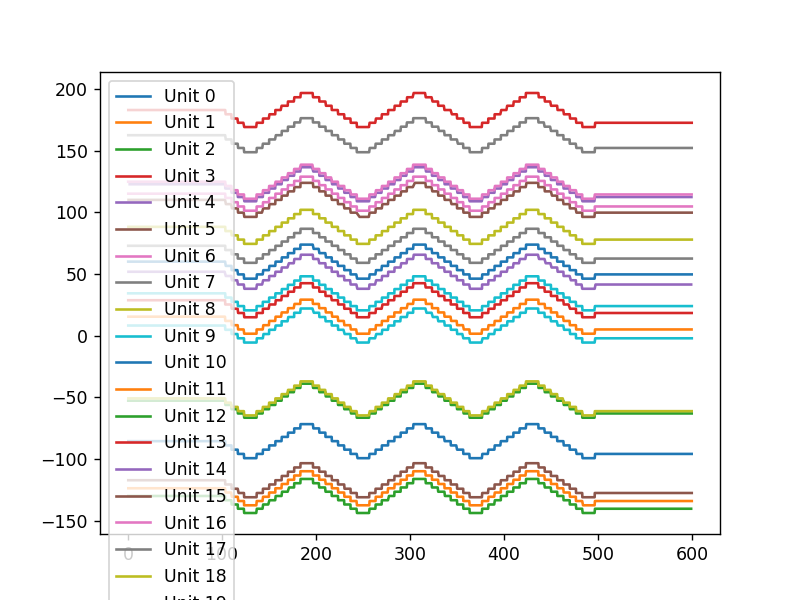

<IPython.core.display.Javascript object>


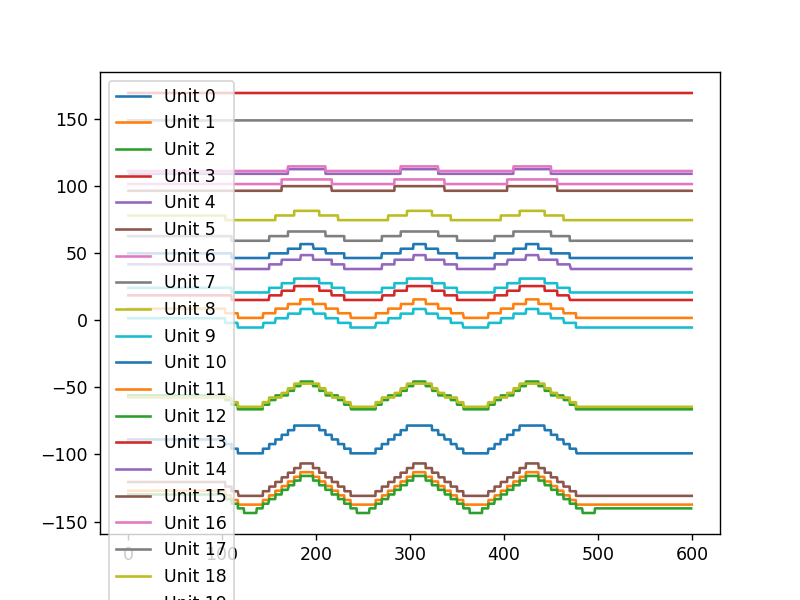

<AxesSubplot:>

In [17]:
mr.plot_cell_drifts(recgen_rigid_loaded)
mr.plot_cell_drifts(recgen_non_rigid_loaded)

## Use multiple drift signals

In order to construct more complicated drifts, we can use a combination of multiple drift signals.
In this example, we show how to combine 3 drift signals:
1. a slow rigid drift with velocity 10um/min
2. a fast rigi drift with events every 60s
3. an additional non-rigid fast sine oscillation

In [29]:
drift_dict_slow = mr.get_default_drift_dict()
drift_dict_fast = mr.get_default_drift_dict()
drift_dict_slow_nonrigid = mr.get_default_drift_dict()

In [30]:
drift_dict_slow["drift_mode_probe"] = "rigid"
drift_dict_slow["drift_fs"] = 5
drift_dict_slow["slow_drift_velocity"] = 10
drift_dict_slow["slow_drift_amplitude"] = 50

In [31]:
drift_dict_fast["drift_mode_speed"] = "fast"
drift_dict_fast["fast_drift_period"] = 60
drift_dict_fast["fast_drift_max_jump"] = 15

In [32]:
drift_dict_slow_nonrigid["drift_mode_probe"] = "non-rigid"
drift_dict_slow_nonrigid["drift_mode_speed"] = "slow"
drift_dict_slow_nonrigid["slow_drift_waveform"] = "sine"
drift_dict_slow_nonrigid["slow_drift_velocity"] = 80
drift_dict_slow_nonrigid["slow_drift_amplitude"] = 10

In [33]:
drift_dicts = [drift_dict_slow, drift_dict_fast, drift_dict_slow_nonrigid]

In [34]:
recgen_mixed = mr.gen_recordings(templates='data/test_drift_templates.h5', 
                                 params=recordings_params, verbose=True,
                                 n_jobs=10, drift_dicts=drift_dicts)

Loading templates...
Done loading templates...
Spiketrains seed:  3162
dtype float32
Noise Level  10
Using 3 custom drift signals
Templates selection seed:  6714
Selecting cells
Num. of drift vectors shape 3 with [3000, 60000, 60000] samples
Padding template edges
Elapsed pad time: 3.6607589721679688
Creating time jittering
Elapsed jitter time: 1.9428391456604004
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  183
Electrode modulaton
Adding noise
Noise seed:  5481
Elapsed time:  24.93209969298914


In [35]:
mr.save_recording_generator(recgen_mixed, filename='data/test_drift_recordings_mixed.h5')
recgen_mixed_loaded = mr.load_recordings('data/test_drift_recordings_mixed.h5')

<IPython.core.display.Javascript object>


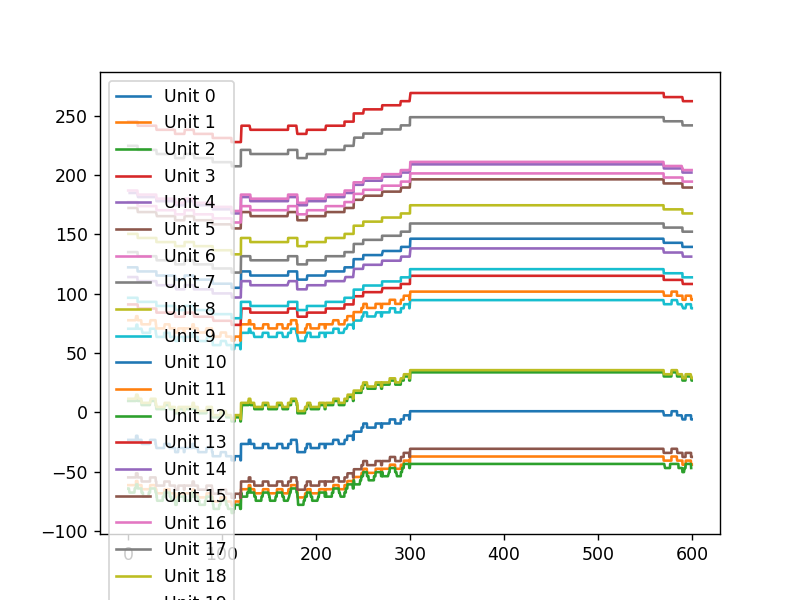

<AxesSubplot:>

In [36]:
mr.plot_cell_drifts(recgen_mixed_loaded)